# Basic Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from geopy.distance import geodesic

## Functions

In [32]:
def calculate_distance(row):
    start_point = (row['start_lat'], row['start_lng'])
    end_point = (row['end_lat'], row['end_lng'])
    return geodesic(start_point, end_point).miles

### Load and Clean Data

In [3]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
dataframes = {}
base_path = '2024_Dataset/Data-IO_2024_Dataset/'

for month in months:
    file_path = f"{base_path}{month}.csv"
    dataframes[month.lower() + '_df'] = pd.read_csv(file_path)
    dataframes[month.lower() + '_df']['started_at'] = pd.to_datetime(dataframes[month.lower() + '_df']['started_at'])
    dataframes[month.lower() + '_df']['ended_at'] = pd.to_datetime(dataframes[month.lower() + '_df']['ended_at'])
    dataframes[month.lower() + '_df']['ride_duration'] = dataframes[month.lower() + '_df']['ended_at'] - dataframes[month.lower() + '_df']['started_at']

all_data_df = pd.concat(dataframes.values(), ignore_index=True)
#dataframes['january_df']

In [17]:
total_sum = 0
for month in months:
    print(month , ":" , len(dataframes[month.lower() + '_df']))
    total_sum += len(dataframes[month.lower() + '_df'])
print("total:", total_sum)
#print("all_data_df length:", len(all_data_df))

January : 190301
February : 190445
March : 258678
April : 426590
May : 604827
June : 769204
July : 823488
August : 785932
September : 701339
October : 558685
November : 337735
December : 181806
total: 5829030
all_data_df length: 5829030


In [ ]:
df_cleaned = all_data_df.dropna()
df_cleaned['ride_distance'] = df_cleaned.apply(calculate_distance, axis=1)

In [19]:
print(len(all_data_df))
print(len(df_cleaned))

5829030
4494681


In [22]:
member_ride_duration = all_data_df.groupby('member_casual')['ride_duration'].mean()
type_ride_duration = all_data_df.groupby('rideable_type')['ride_duration'].mean()

In [23]:
member_ride_distance = df_cleaned.groupby('member_casual')['ride_distance'].mean()
type_ride_distance = df_cleaned.groupby('rideable_type')['ride_distance'].mean()

### Statistics From Data

In [28]:
member_ride_duration.head(5)

member_casual
casual   0 days 00:28:12.465902244
member   0 days 00:12:27.986372594
Name: ride_duration, dtype: timedelta64[ns]

In [29]:
type_ride_duration.head(5)

rideable_type
classic_bike    0 days 00:18:36.209827254
docked_bike     0 days 02:14:17.504735974
electric_bike   0 days 00:12:54.424734748
Name: ride_duration, dtype: timedelta64[ns]

In [30]:
member_ride_distance.head(5)

member_casual
casual    1.324334
member    1.278365
Name: ride_distance, dtype: float64

In [31]:
type_ride_distance.head(5)

rideable_type
classic_bike     1.238279
docked_bike      1.352423
electric_bike    1.376658
Name: ride_distance, dtype: float64

### Seasonality

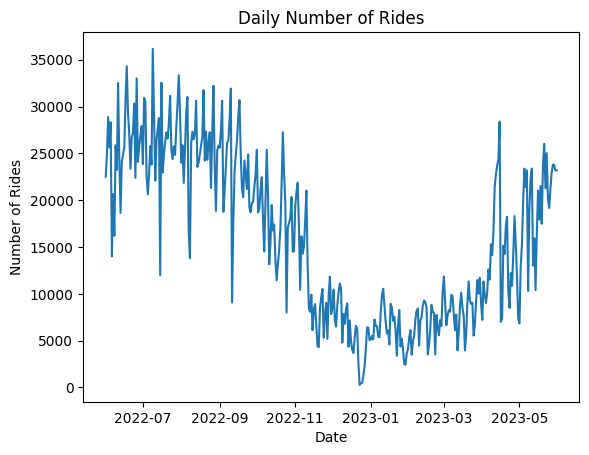

In [9]:
all_data_df['started_at_date'] = all_data_df['started_at'].dt.date
all_data_df.groupby('started_at_date').size().plot(kind='line')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.title('Daily Number of Rides')
plt.show()


Prime Bike Season: June - October; 
Low Bike Season: November - May

### Trending Location

In [51]:
user_choice = input("Do you want to view a 'start' or an 'end' station map? (start/end): ")
if user_choice == 'start':
    stations = all_data_df['start_station_name'].unique()
elif user_choice == 'end':
    stations = all_data_df['end_station_name'].unique()

for idx, station in enumerate(stations, start=1):
    print(f"{idx}. {station}")

1. Hampden Ct & Diversey Ave
2. Greenwood Ave & 47th St
3. Valli Produce - Evanston Plaza
4. Warren Park West
5. Clark St & Elmdale Ave
6. Campbell Ave & Irving Park Rd
7. Pulaski Rd & 51st St
8. Sacramento Blvd & Franklin Blvd
9. Elmwood Ave & Austin St
10. Adler Planetarium
11. McClurg Ct & Ohio St
12. Wood St & Taylor St (Temp)
13. Stetson Ave & South Water St
14. Ashland Ave & Belle Plaine Ave
15. Walsh Park
16. Manor Ave & Leland Ave
17. Public Rack - Racine Ave & 109th Pl
18. Public Rack - Kedzie Ave & Argyle St
19. Canal St & Jackson Blvd
20. Albany Ave & Bloomingdale Ave
21. Racine Ave & 61st St
22. Western Ave & Gunnison St
23. Ada St & 113th St
24. Halsted St & 37th St
25. Austin Blvd & Madison St
26. Hermitage Ave & Polk St
27. Public Rack - Cicero Ave & Wrightwood Ave
28. Kilpatrick Ave & Grand Ave
29. MLK Jr Dr & 63rd St
30. Harlem & Irving Park
31. Halsted St & 69th St
32. Canal St & Monroe St
33. Michigan Ave & 8th St
34. Racine Ave & Belmont Ave
35. Racine Ave & 15th St

In [52]:
station_index = int(input("Select the station by number: ")) - 1
selected_station = stations[station_index]

if user_choice == 'start':
    filtered_df = all_data_df[all_data_df['start_station_name'] == selected_station].drop_duplicates(subset=['end_station_name'])
else:
    filtered_df = all_data_df[all_data_df['end_station_name'] == selected_station].drop_duplicates(subset=['start_station_name'])

map_center = [filtered_df['start_lat'].mean(), filtered_df['start_lng'].mean()]
m = folium.Map(location=map_center, zoom_start=13)

for idx, row in filtered_df.iterrows():
    start_point = [row['start_lat'], row['start_lng']]
    end_point = [row['end_lat'], row['end_lng']]
    
    if user_choice == 'start':
        folium.Marker(start_point, popup=row['start_station_name'], icon=folium.Icon(color='green')).add_to(m)
        folium.Marker(end_point, popup=row['end_station_name'], icon=folium.Icon(color='red')).add_to(m)
    else:
        folium.Marker(end_point, popup=row['end_station_name'], icon=folium.Icon(color='green')).add_to(m)
        folium.Marker(start_point, popup=row['start_station_name'], icon=folium.Icon(color='red')).add_to(m)

    folium.PolyLine(locations=[start_point, end_point], color='blue').add_to(m)

m
